In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import math
import os
import collections
import dscrutils2py as dscrutils

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from pymir import mpl_stylesheet
from pymir import mpl_utils
from pymir import pd_utils

mpl_stylesheet.banskt_presentation(splinecolor = 'black', dpi = 72)

INFO: cffi mode is CFFI_MODE.ANY
INFO: R home found: /software/R-3.6.1-el7-x86_64/lib64/R
INFO: R library path: /software/R-3.6.1-el7-x86_64/lib64/R/lib:/usr/local/lib64:/software/java-1.8-x86_64/jre/lib/amd64/server:/software/intel/parallel_studio_xe_2020_update1/mkl/lib/intel64:/software/R-3.6.1-el7-x86_64/lib64/R/lib:/software/R-3.6.1-el7-x86_64/lib64:/software/curl-7.50-el7-x86_64/lib:/software/java-1.8-x86_64/lib:/software/openblas-0.2.19-el7-x86_64/lib:/software/gcc-10.2.0-el7-x86_64/lib64:/software/gcc-10.2.0-el7-x86_64/lib:/software/slurm-current-el7-x86_64/lib64:/software/slurm-current-el7-x86_64/lib:/software/git-2.10-el7-x86_64/lib64:/software/subversion-1.9.4-el7-x86_64/lib:/software/serf-1.3.9-el7-x86_64/lib
INFO: LD_LIBRARY_PATH: /software/intel/parallel_studio_xe_2020_update1/mkl/lib/intel64:/software/R-3.6.1-el7-x86_64/lib64/R/lib:/software/R-3.6.1-el7-x86_64/lib64:/software/curl-7.50-el7-x86_64/lib:/software/java-1.8-x86_64/lib:/software/openblas-0.2.19-el7-x86_64/lib:

In [2]:
dsc_outdir = os.path.realpath("/home/saikatbanerjee/scratch-midway2/gradvi-experiments/trial")

# methods in the simulation
methods = [
    "ridge", "lasso", "elastic_net",
    "lasso_1se", "elastic_net_1se", 
    "scad", "mcp", "l0learn",
    "susie", "varbvs", "varbvsmix", "blasso", "bayesb",
    "mr_ash", "mr_ash_lasso_init", 
    "gradvi_direct", "gradvi_compound"
]
dims = [(50, 200),]
sfix = [1, 2, 5, 10]
targets = ["simulate", "simulate.dims", "simulate.se", "simulate.rho",
           "simulate.sfix", "simulate.pve", "fit", "fit.DSC_TIME", 
           "mse.err", "coef_mse.err"]

In [3]:
%%capture capt
dscout = dscrutils.dscquery(dsc_outdir, targets)

In [4]:
capt.show()

Calling: dsc-query /scratch/midway2/saikatbanerjee/gradvi-experiments/trial -o /tmp/RtmpINp5zY/filed52d4dd54148.csv --target "simulate simulate.dims simulate.se simulate.rho simulate.sfix simulate.pve fit fit.DSC_TIME mse.err coef_mse.err" --force 
Loaded dscquery output table with 272 rows and 13 columns.



In [5]:
dscout

,DSC,simulate,simulate.dims,simulate.se,simulate.rho,simulate.sfix,simulate.pve,fit,fit.DSC_TIME,mse.err,coef_mse.err
0,1,equicorrgauss,"(50,200)",0.192352,0.6,1,0.8,susie,14.021,0.044952,NaN
1,1,equicorrgauss,"(50,200)",0.277475,0.6,2,0.8,susie,14.245,0.085725,NaN
2,1,equicorrgauss,"(50,200)",0.964741,0.6,5,0.8,susie,14.408,2.281050,NaN
3,1,equicorrgauss,"(50,200)",1.494825,0.6,10,0.8,susie,8.685,3.961300,NaN
4,2,equicorrgauss,"(50,200)",0.509526,0.6,1,0.8,susie,8.213,0.265067,NaN
...,...,...,...,...,...,...,...,...,...,...,...
267,1,equicorrgauss,"(50,200)",1.494825,0.6,10,0.8,l0learn,3.135,NaN,0.030774
268,2,equicorrgauss,"(50,200)",0.509526,0.6,1,0.8,l0learn,1.850,NaN,0.000333
269,2,equicorrgauss,"(50,200)",0.210345,0.6,2,0.8,l0learn,1.711,NaN,0.000831
270,2,equicorrgauss,"(50,200)",1.812334,0.6,5,0.8,l0learn,1.865,NaN,0.045419


In [6]:
import methodprops

In [10]:
import pickle
dscout.to_pickle("/home/saikatbanerjee/work/sparse-regression/gradvi-experiments/results/trial_dscout.pkl")

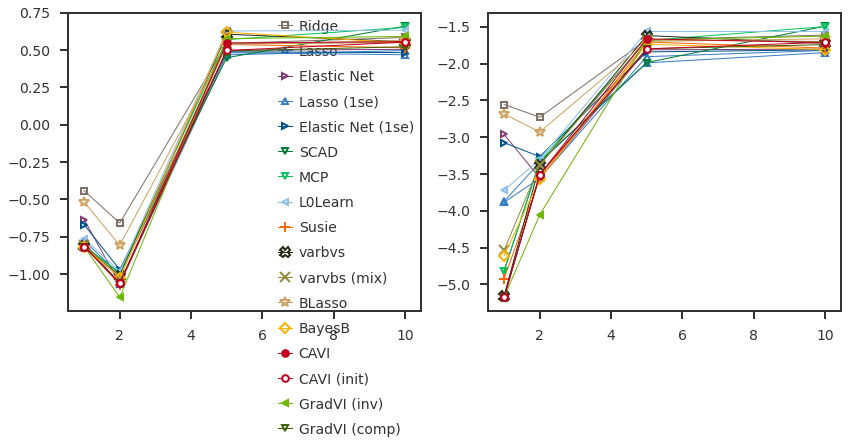

In [9]:
def single_plot_score_methods(ax, resdf, colname, methods, sfix):
    plotmeta = methodprops.plot_metainfo()
    xscale   = 'linear'
    yscale   = 'log10'
    xvals    = [x for x in sfix]
    for method in methods:
        #if method == 'mr_ash_lasso_init':
        #    pm = plotmeta['mr_ash_init']
        #else:
        pm  = plotmeta[method]
        mconditions = [f"$(fit) == {method}"]
        dfm = pd_utils.select_dfrows(resdf, mconditions)
        dfs = dfm[~dfm[colname].isnull()]
        score = [0 for x in sfix]
        for i, s in enumerate(sfix):
            sfix_cond = [f"$(simulate.sfix) == {s}"]
            dfselect = pd_utils.select_dfrows(dfs, sfix_cond)
            score[i] = np.mean(dfselect[colname].to_numpy())

        ax.plot(
            mpl_utils.scale_array(xvals, xscale), 
            mpl_utils.scale_array(score, yscale), 
            label = pm.label, color = pm.color, lw = pm.linewidth / 2, 
            ls = pm.linestyle, marker = pm.marker, ms = pm.size / 1.2, 
            mec = pm.color, mfc = pm.facecolor, mew = pm.linewidth,
            zorder = pm.zorder)
    return

fig = plt.figure(figsize = (12, 6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
single_plot_score_methods(ax1, dscout, 'mse.err', methods, sfix)
single_plot_score_methods(ax2, dscout, 'coef_mse.err', methods, sfix)

ax1.legend()
plt.tight_layout()
plt.show()